# ML Final Project: Predicting Gender and Age based on Search Keywords

### *Group 9: Amélie Pingeot, Taanya Sachdeva, Maxime Pracisnore, Maximilian Baum, Thomas Vermaelen*

In [1]:
import os
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, auc, roc_curve
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import StratifiedKFold
from scipy import sparse, interp
import spacy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statistics
import math
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


## I. Data Preparation

In [2]:
os.chdir("/Users/thomasvermaelen/Documents/ESCP/Machine Learning in Python/Default Final Project")
nlp = spacy.load("fr_core_news_sm")
data_train = pd.read_csv("train.csv")
data_train = data_train.dropna().copy()
samp_size = 50000
data_train= data_train.sample(n=samp_size, random_state=123)
data_train.head()

,ID,keywords,age,sex
3901146,612587,france:1;meteo:1;rochelle:1;previsions:1;ville:1,48,F
4520225,91239,definition:1;instruction:1;juridique:1;faq:1,49,F
5660679,15229,ligue:1;champions:1;cinq:1;actualites:1;des:1;...,55,M
230078,308637,detail_offre:1;emploi:1,37,M
2640202,292989,rapides:1;faciles:1;enfants:1;recettes:1;pour:...,65,M


Class repartition of the target variable 'Sex'

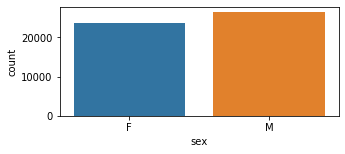

In [3]:
ax  = plt.figure(figsize=(5,2))
sns.countplot(data=data_train, x='sex')

In [4]:
def clean_text(df):   
    #this will help for regex matching
    df.keywords = ";"+df.keywords+";"
    df.keywords = [keyword.lower() for keyword in df.keywords]
    # seperate frequencies from words
    df["frequency"] = [list(map(int, re.findall(":(.+?);",text)))  for text in df.keywords]
    df["words"] = [re.findall(";(.+?):",text) for text in df.keywords]
    stemmer = SnowballStemmer(language='french')
    df["words_stem"] = [[stemmer.stem(word) for word in words] for words in df.words]
    
    # multiply words by their respective frequencies
    df["text"] = [[(word+" ") * freq for word, freq in zip(words, freqs)] for words, freqs in zip(df.words_stem, df.frequency)]
    df["text"] = ["".join(text) for text in df.text]
    df["text"] = [re.sub(r'\w*[0-9]\w*', "",text) for text in df.text]
    df["text"] = [re.sub(r'\w*html\w*', '', text) for text in df.text]
    df["text"] = [re.sub(r'\w*%\w*', '', text) for text in df.text]
    df["text"]= [re.sub('[!"#%\'()*+,./:;<=>?@\[\]^_`{|}~’”“′‘\\\]',' ', text) for text in df.text]
    
    tokenizer = TweetTokenizer()
    df["text_token"] = df["text"].apply(tokenizer.tokenize)
    return(df)
data_train = clean_text(data_train)
data_train.head()

,ID,keywords,age,sex,frequency,words,words_stem,text,text_token
3901146,612587,;france:1;meteo:1;rochelle:1;previsions:1;vill...,48,F,"[1, 1, 1, 1, 1]","[france, meteo, rochelle, previsions, ville]","[franc, meteo, rochel, previs, vill]",franc meteo rochel previs vill,"[franc, meteo, rochel, previs, vill]"
4520225,91239,;definition:1;instruction:1;juridique:1;faq:1;,49,F,"[1, 1, 1, 1]","[definition, instruction, juridique, faq]","[definit, instruct, jurid, faq]",definit instruct jurid faq,"[definit, instruct, jurid, faq]"
5660679,15229,;ligue:1;champions:1;cinq:1;actualites:1;des:1...,55,M,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[ligue, champions, cinq, actualites, des, foot...","[ligu, champion, cinq, actualit, de, football,...",ligu champion cinq actualit de football suivr ...,"[ligu, champion, cinq, actualit, de, football,..."
230078,308637,;detail_offre:1;emploi:1;,37,M,"[1, 1]","[detail_offre, emploi]","[detail_offr, emploi]",detail offr emploi,"[detail, offr, emploi]"
2640202,292989,;rapides:1;faciles:1;enfants:1;recettes:1;pour...,65,M,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[rapides, faciles, enfants, recettes, pour, pl...","[rapid, facil, enfant, recet, pour, plus, nos,...",rapid facil enfant recet pour plus nos rentre ...,"[rapid, facil, enfant, recet, pour, plus, nos,..."


Train/Test Split

In [5]:
X =  data_train.text
sex= data_train.sex.map({'F':1, 'M':0})
X_train, X_test, sex_train, sex_test = train_test_split(X,sex, test_size=0.2, random_state=123)
age_train = data_train.loc[X_train.index,:].age
age_test = data_train.loc[X_test.index,:].age

In [6]:
# this function plots roc curves using 5-Fold cross validation
def plot_roc_cv(x_train, x_test, y_train, y_test, clf, model_name):
    y_train.index = range(len(y_train))
    cv = StratifiedKFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 500)
    random.seed(123)
    for i, (train, test) in enumerate(cv.split(x_train, y_train)):
        clf.fit(x_train[train], y_train[train])
        proba_val= clf.predict_proba(x_train[test])[:,1]
        fpr_val,tpr_val,cutoffs = roc_curve(y_train[test], proba_val)
        interp_tpr = interp(mean_fpr, fpr_val, tpr_val)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr_val, tpr_val))   
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    pred_test = clf.predict(x_test)
    prob_test= clf.predict_proba(x_test)[:,1]
    fpr_test, tpr_test, cutoffs = roc_curve(y_test, prob_test)
    print("Classification report for test set:")
    print(classification_report(y_test,pred_test))
    plt.title("ROC Curve for {} Model of Sex".format(model_name))
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    roc_train, = plt.plot(mean_fpr, mean_tpr, 
                          label ="Mean AUC train (5-fold CV): {:.3}".format(mean_auc), 
                          c= "blue")
    roc_test, = plt.plot(fpr_test, tpr_test, 
                         label ="AUC test: {:.3}".format(auc(fpr_test, tpr_test)),
                         c= "orange")

    chance, = plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                       label = "Chance", alpha=.8)
    plt.legend(handles=[roc_train,roc_test, chance])

## II. Modeling Sex

### II. A)  Tf-Idf with Full Vocabulary

In [7]:
# FULL VOCAB 
stop_words = stopwords.words('french') + stopwords.words('english')
# tokenize and build initial vocabulary
tfidf_vect_full = TfidfVectorizer(stop_words=stop_words)
tfidf_vect_full.fit(X_train)
print("Length of Full Vocab: {}".format(len(tfidf_vect_full.vocabulary_)))

Length of Full Vocab: 31066


In [8]:
# TRAIN FULL VOCAB
X_train_full_vocab = tfidf_vect_full.transform(X_train)
X_test_full_vocab = tfidf_vect_full.transform(X_test)


#### Logistic Regression (Tf-Idf Full Vocab)

Classification report for test set:
              precision    recall  f1-score   support

           0       0.59      0.66      0.63      5323
           1       0.56      0.48      0.51      4677

    accuracy                           0.58     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.58      0.57     10000



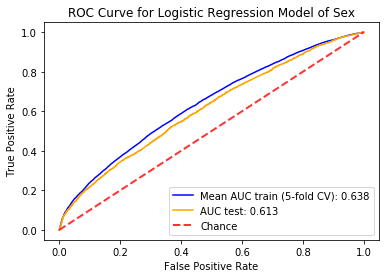

In [9]:
lr_mod = LogisticRegression(penalty='l2', max_iter = 1000)
plot_roc_cv(X_train_full_vocab,X_test_full_vocab, sex_train,sex_test, lr_mod, "Logistic Regression")


#### Multinomial Naive Bayes (Tf-Idf Full Vocab)

Classification report for test set:
              precision    recall  f1-score   support

           0       0.59      0.73      0.65      5323
           1       0.58      0.41      0.48      4677

    accuracy                           0.58     10000
   macro avg       0.58      0.57      0.57     10000
weighted avg       0.58      0.58      0.57     10000



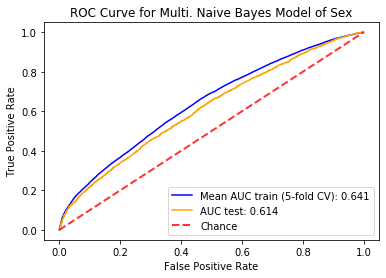

In [10]:
mnb_mod = MultinomialNB()
plot_roc_cv(X_train_full_vocab,X_test_full_vocab, sex_train,sex_test, mnb_mod, "Multi. Naive Bayes")

### II. B) Tf-Idf with Reduced Vocabulary (Nouns and Verbs only)

In [11]:
############# NEW VOCAB ########################
# retrieve nouns and verbs only from vocabulary
voc= tfidf_vect_full.vocabulary_ 
voc_keys = list(voc.keys())
voc_keys = nlp(" ".join(voc_keys))
voc_tags = [word for word in voc_keys if word.pos_=="NOUN" or word.pos_=="PROPN" or word.pos_=="VERB" ]

# voc_tags = [word for word in voc_keys if word.pos_=="NOUN" or  word.pos_=="VERB" or word.pos_=="PROPN"or word.pos_=="ADJ"or word.pos_=="ADV"]
nouns_verbs = [str(voc_tags[i]) for i in range(len(voc_tags))]
new_voc = dict(zip(nouns_verbs, range(0, len(nouns_verbs))))
new_voc = dict((k, voc[k]) for k in nouns_verbs)
new_voc = dict(zip(list(new_voc.keys()), range(0,len(new_voc))))

# vectorize once more using new vocabulary
tfidf_vect_new = TfidfVectorizer(stop_words=stop_words,vocabulary = new_voc)
tfidf_vect_new.fit(X_train)
print("Length of New Vocab: {}".format(len(tfidf_vect_new.vocabulary_)))


Length of New Vocab: 20055


In [12]:
# TRAIN NEW VOCAB
X_train_new_vocab = tfidf_vect_new.transform(X_train)
X_test_new_vocab = tfidf_vect_new.transform(X_test)

#### Logistic Regression (Tf-Idf New Vocab)

Classification report for test set:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64      5323
           1       0.57      0.45      0.50      4677

    accuracy                           0.58     10000
   macro avg       0.58      0.57      0.57     10000
weighted avg       0.58      0.58      0.57     10000



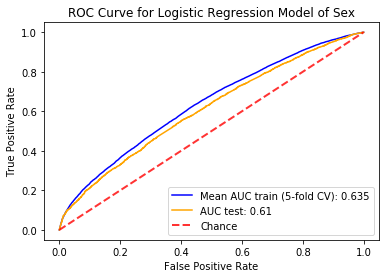

In [13]:
plot_roc_cv(X_train_new_vocab, X_test_new_vocab, sex_train,sex_test, lr_mod, "Logistic Regression")

#### Multinomial Naive Bayes (Tf-Idf New Vocab)

Classification report for test set:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66      5323
           1       0.58      0.39      0.46      4677

    accuracy                           0.58     10000
   macro avg       0.58      0.57      0.56     10000
weighted avg       0.58      0.58      0.57     10000



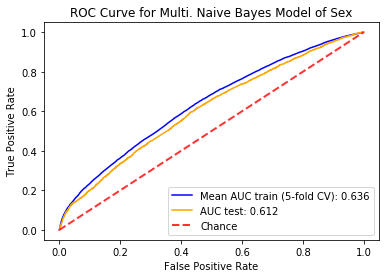

In [14]:
plot_roc_cv(X_train_new_vocab, X_test_new_vocab, sex_train,sex_test, mnb_mod, "Multi. Naive Bayes")

### II. C) Word2Vec

In [15]:
### WOrd2Vec
emb_size = 128

#Initialize model_w2v and build vocabularies
model_w2v = Word2Vec(size=emb_size, min_count=5)
model_w2v.build_vocab(X_train) 
model_w2v.train(X_train, total_examples=model_w2v.corpus_count, epochs=500)

#Build word vector for training set 
def build_word2vec_from_text(model_w2v, sentence, emb_size):
    emb_vec = np.zeros(emb_size).reshape((1, emb_size))
    count = 0.
    for word in sentence:
        try:
            emb_vec += model_w2v[word].reshape((1, emb_size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        emb_vec /= count
    return emb_vec

X_train_vec = np.concatenate([build_word2vec_from_text(model_w2v, d, emb_size) for d in X_train], axis=0)
X_test_vec =np.concatenate([build_word2vec_from_text(model_w2v, d, emb_size) for d in X_test])


# you can test with MinMaxNormalization
scale = StandardScaler()
scale.fit(X_train_vec)
X_train_scaled = sparse.csr_matrix(scale.transform(X_train_vec))
X_test_scaled = sparse.csr_matrix(scale.transform(X_test_vec))

#### Logistic Regression (Word2Vec)

Classification report for test set:
              precision    recall  f1-score   support

           0       0.55      0.80      0.65      5323
           1       0.53      0.26      0.35      4677

    accuracy                           0.55     10000
   macro avg       0.54      0.53      0.50     10000
weighted avg       0.54      0.55      0.51     10000



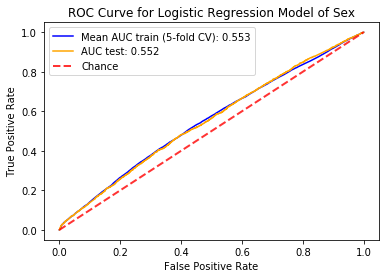

In [16]:
plot_roc_cv(X_train_scaled, X_test_scaled, sex_train,sex_test, lr_mod, "Logistic Regression")

#### Random Forest (Word2Vec)

Classification report for test set:
              precision    recall  f1-score   support

           0       0.57      0.66      0.61      5323
           1       0.53      0.44      0.48      4677

    accuracy                           0.56     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.56      0.55     10000



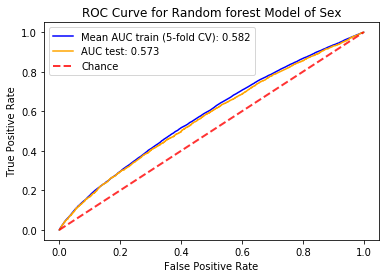

In [17]:
rf_mod = RandomForestClassifier(n_estimators=100, random_state=42)
plot_roc_cv(X_train_scaled, X_test_scaled, sex_train,sex_test, rf_mod, "Random forest")

### II. D) Neural Network (with Tf-Idf Embeddings)

In [18]:
# Check if Keras uses GPU
from keras import backend as K

train_sentences = X_train.values
test_sentences = X_test.values
train_labels = sex_train.values
test_labels = sex_test.values

num_labels = 2
vocab_size = int(len(tfidf_vect_full.vocabulary_)*0.05)
batch_size = 1000
embedding_vector_length = 300

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences)
x_train = tokenizer.texts_to_matrix(train_sentences, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_sentences, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_train = np.hstack((y_train, 1 - y_train))
y_test = encoder.transform(test_labels)
y_test = np.hstack((y_test, 1 - y_test))

dnn_mod = Sequential()
dnn_mod.add(Dense(50, input_shape=(vocab_size,)))
dnn_mod.add(Dense(num_labels))
dnn_mod.add(Activation('sigmoid'))
dnn_mod.summary()

random.seed(123) 

    
dnn_mod.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', 
                     verbose=1, save_best_only=True)
history = dnn_mod.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1,
                    validation_split=0.2, callbacks = [es, mc])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                77700     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 77,802
Trainable params: 77,802
Non-trainable params: 0
_________________________________________________________________
Train on 32000 samples, validate on 8000 samples
Epoch 1/100
32000/32000 [==============================] - 1s 27us/step - loss: 0.6905 - accuracy: 0.5658 - val_loss: 0.6733 - val_accuracy: 0.5943

Epoch 00001: val_accuracy improved from -inf to 0.59425, saving model to best_model.h5
Epoch 2/100
32000/32000 [==============================] - 1s 18us/step - loss: 0.6532 - accura

Classification report for test set:
              precision    recall  f1-score   support

           0       0.56      0.49      0.52      4677
           1       0.60      0.66      0.63      5323

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



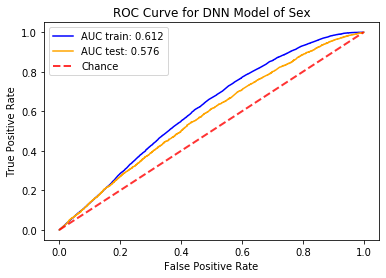

In [19]:
sex_pred_train= dnn_mod.predict_proba(x_train)[:,1] 
sex_train_binary = sex_train.apply(lambda x: 1 if x ==0 else 0)
fpr_train, tpr_train, cutoffs = roc_curve(sex_train_binary, sex_pred_train)

sex_pred_test= dnn_mod.predict_proba(x_test)[:,1] 
sex_test_binary = sex_test.apply(lambda x: 1 if x ==0 else 0)
fpr_test, tpr_test, cutoffs = roc_curve(sex_test_binary, sex_pred_test)

sex_pred_class_test=dnn_mod.predict_classes(x_test)
print("Classification report for test set:")
print(classification_report(sex_test_binary,sex_pred_class_test))

plt.title("ROC Curve for DNN Model of Sex")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
roc_train, = plt.plot(fpr_train, tpr_train, 
                          label ="AUC train: {:.3}".format(auc(fpr_train, tpr_train)), 
                      c= "blue")
roc_test, = plt.plot(fpr_test, tpr_test, 
                         label ="AUC test: {:.3}".format(auc(fpr_test, tpr_test)),
                         c= "orange")
chance, = plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                       label = "Chance", alpha=.8)
plt.legend(handles=[roc_train,roc_test, chance])

#### Conclusion: Multinomial Naive Bayes with Tf-Idf Embeddings yielded the best testing metrics (Accuracy = 58%, AUC = 61.4%), so we will use it to predict "Sex" for the provided test dataset

## III. Predicting Sex With Multinomial Naive Bayes and Tf-Idf Embeddings

In [20]:
#########Predict on a sample of the provided test dataset #########
data_test = pd.read_csv("test.csv")
data_test = data_test.drop(columns=["age", "sex"]).copy()
data_test = data_test.dropna()
data_test = data_test.sample(n = samp_size, random_state=123)
data_test= clean_text(data_test)

# fit tfidf on full train data
tfidf_vect_full.fit(data_train.text)

X_data_train = tfidf_vect_full.transform(data_train.text)
y = data_train.sex.map({'F':1, 'M':0})
mnb_mod = MultinomialNB()
mnb_mod.fit(X_data_train, y)

X_data_test = tfidf_vect_full.transform(data_test.text)
sex_pred_final = mnb_mod.predict(X_data_test)
sex_pred_final = np.where(sex_pred_final==1, "F", "M")
data_test["sex_prediction"] = sex_pred_final

## IV. Modeling Age

In [21]:
# AGE MODELING
 ######### FULL VOCAB ###################
def score_age_model(x_train, x_test, y_train, y_test, mod):
    mod.fit(x_train,y_train)
    pred_train = mod.predict(x_train)
    print('Root Mean Squared Error:',math.sqrt(metrics.mean_squared_error(y_train, pred_train)))
    pred_test = mod.predict(x_test)
    print('Root Mean Squared Error (Test):', math.sqrt(metrics.mean_squared_error(y_test, pred_test)))


### IV. A) Tf-Idf Full Vocabulary

In [22]:
# Linear Regression
lm = LinearRegression()
print("Linear Regression scores (Tf-idf full vocab):")
score_age_model(X_train_full_vocab, X_test_full_vocab, age_train, age_test, lm)


Linear Regression scores (Tf-idf full vocab):
Root Mean Squared Error: 8.62598807554911
Root Mean Squared Error (Test): 63.72276579663561


In [23]:
#  Random Forest
print("Random Forest scores (Tf-idf full vocab)):")
score_age_model(X_train_full_vocab, X_test_full_vocab, age_train, age_test, rf_mod)

Random Forest scores (Tf-idf full vocab)):
Root Mean Squared Error: 8.04264104632303
Root Mean Squared Error (Test): 16.542342639420813


### IV. B) Tf-Idf Reduced Vocabulary (Nouns and Verbs only)

In [24]:
######### NEW VOCAB ############
print("Linear Regression (Tf-idf new vocab):")
# Lin regression
score_age_model(X_train_new_vocab, X_test_new_vocab, age_train, age_test, lm)


Linear Regression (Tf-idf new vocab):
Root Mean Squared Error: 9.902500164418019
Root Mean Squared Error (Test): 89.5590398559217


In [25]:
print("Random Forest scores (Tf-idf new vocab):")
#  Random Forest
score_age_model(X_train_new_vocab, X_test_new_vocab, age_train, age_test, rf_mod)


Random Forest scores (Tf-idf new vocab):
Root Mean Squared Error: 9.199597817296144
Root Mean Squared Error (Test): 17.182342680787155


### IV. C) Word2Vec

In [26]:
##### Word2vec #####
# Lin Reg
print("Linear Regression scores (Word2vec):")
score_age_model(X_train_scaled, X_test_scaled, age_train, age_test, lm)

Linear Regression scores (Word2vec):
Root Mean Squared Error: 13.026672551590558
Root Mean Squared Error (Test): 13.023369090134473


In [27]:
#  Random Forest
print("Random Forest scores (Word2vec):")
score_age_model(X_train_scaled, X_test_scaled, age_train, age_test, rf_mod)

Random Forest scores (Word2vec):
Root Mean Squared Error: 8.039867847172614
Root Mean Squared Error (Test): 15.898242041181787


#### Conclusion: Linear regression with Word2Vec yielded the lowest testing RMSE (13.02), therefore, we will use this model to predict age.

## V. Predicting Age with Linear Regression and Word2Vec

In [28]:
# Train Word2vec on full training set
model_w2v.train(data_train.text, total_examples=model_w2v.corpus_count, epochs=500)
X_train_vec = np.concatenate([build_word2vec_from_text(model_w2v, d, emb_size) for d in data_train.text], axis=0)
y = data_train.age
scale.fit(X_train_vec)
# Fit word2vec on train and test sets
X_train_scaled = sparse.csr_matrix(scale.transform(X_train_vec))
lm.fit(X_train_scaled, y)
X_test_vec = np.concatenate([build_word2vec_from_text(model_w2v, d, emb_size) for d in data_test.text], axis=0)
# predict age based on Linear Regression
age_pred_final = lm.predict(X_test_vec)
data_test["age_prediction"] = np.array(round(pd.DataFrame(age_pred_final),0))
data_test = data_test.drop(columns = ["keywords","frequency", "words", "words_stem", "text", "text_token"])
data_test.head()

,ID,sex_prediction,age_prediction
1235190,1235191,M,75.0
2127044,2127045,M,56.0
2285345,2285346,M,76.0
2957002,2957003,M,79.0
1232202,1232203,M,70.0


Save results to csv

In [29]:
data_test.to_csv("test_predictions.csv")